# Projeto 1 - Ciência dos Dados

Nome: Ricardo Ribeiro Rodrigues 

Nome: Guilherme da Franca Silva Escobar

Atenção: Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

___
Carregando algumas bibliotecas:

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
C:\Users\riywa\Desktop\Ciencia_de_dados\Projeto1-CDados


Carregando a base de dados com os tweets classificados como relevantes e não relevantes:

In [3]:
filename = 'WandaVision.xlsx'

In [4]:
train = pd.read_excel(filename)
train.head(5)

,Treinamento,Relevancia
0,#wandavision o 8 episódio dá muito susto kkkkk...,1
1,"@_casthr assim, não tô esperando nada, pq eu d...",1
2,@_casthr li que o diretor disse que será total...,0
3,#@_mbheart foi aqui \n\nhttps://t.co/gg4lulxgqf,0
4,"@_pedrolopss dark e wandavision, até pq são as...",1


In [5]:
test = pd.read_excel(filename, sheet_name = 'Teste')
test.head(5)

,Teste,Relevancia
0,"""meninos, cuidem dos militares! a mamãe já vai...",0
1,"""wandavision"" é maravilhosa, gostaria muito de...",1
2,#wandavision já acabou😔mas amanhã tem #thefalc...,1
3,@_entao_ hahaha siiim! bem atualizado assisti ...,0
4,@_pedrolopss sério hehehe? as que eu nunca vi ...,1


___
## Classificador automático de sentimento


Faça aqui uma descrição do seu produto e o que considerou como relevante ou não relevante na classificação dos tweets.

#### Escolhemos como produto a série de tv WandaVision, uma série da Marvel com a Disney Plus.  
### Sinopse: 
  Situada três semanas após os eventos de Vingadores: Ultimato (2019), Wanda Maximoff e Visão estão vivendo uma vida suburbana idílica na cidade de Westview, no estado de New Jersey, tentando esconder suas verdadeiras identidades. À medida que começam a entrar nas novas décadas, o casal suspeita que as coisas não são o que parecem.(Wikipedia)  
### Classificação:  
* Classificamos se o tweet se expressa uma opinião sobre a série ou fala de elementos dela.

___
### Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

In [6]:
import re
import emoji
import functools
import operator
def cleanup(text):
    """
        Função de limpeza muito simples que troca alguns sinais básicos por espaços
    """
    #import string
    punctuation = '[-|><!,-.:#?;""“”\[\]()\\n]' # Note que os sinais [] são delimitadores de um conjunto.
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, '', text)
    return text_subbed

In [7]:
# Limpeza das mensagens relevantes
texto_relevante = ' '.join(train.loc[train.Relevancia == 1, 'Treinamento'])
# Limpeza dos caracteres
texto_relevante = cleanup(texto_relevante.lower())
# Tira links dos tweets
texto_relevante = ' '.join(item for item in texto_relevante.split() if not (item.startswith('https//')))
# Corrige os espaços dos emojis
relevante_split_emoji = emoji.get_emoji_regexp().split(texto_relevante)
relevante_split_whitespace = [substr.split() for substr in relevante_split_emoji]
relevante_split = functools.reduce(operator.concat, relevante_split_whitespace)
texto_relevante = ' '.join(relevante_split)

In [8]:
# Serie relevante e tabela relativa relevante
serie_relevante = pd.Series(texto_relevante.split())
tabela_relativa_relevante = serie_relevante.value_counts(True)
tabela_relativa_relevante

wandavision     0.060992
de              0.033227
que             0.032772
a               0.030041
e               0.020938
                  ...   
escreve         0.000455
@thevisionbr    0.000455
cidade          0.000455
deveriam        0.000455
ataque          0.000455
Length: 821, dtype: float64

In [9]:
# Limpeza das mensagens irrelevantes.
texto_irrelevante = ' '.join(train.loc[train.Relevancia == 0, 'Treinamento'])
# Limpeza dos caracteres
texto_irrelevante = cleanup(texto_irrelevante.lower())
# Tira links dos tweets
texto_irrelevante = ' '.join(item for item in texto_irrelevante.split() if not (item.startswith('https//')))
# Corrige os espaços dos emojis
irrelevante_split_emoji = emoji.get_emoji_regexp().split(texto_irrelevante)
irrelevante_split_whitespace = [substr.split() for substr in irrelevante_split_emoji]
irrelevante_split = functools.reduce(operator.concat, irrelevante_split_whitespace)
texto_irrelevante = ' '.join(irrelevante_split)

## Limpeza dos links
Nos decidimos por fazer uma limpeza dos links contidos nos tweets, visto que eles não contribuíam para a classificação (estão igualmente presentes em relevante e irrelevante) e apenas poluíam as bases de dados.

In [10]:
# Tabela de frequencias das mensagens irrelevantes.
serie_irrelevante = pd.Series(texto_irrelevante.split())
tabela_relativa_irrelevante = serie_irrelevante.value_counts(True)

In [11]:
# Fazendo o total.
todas_mensagens = texto_relevante + texto_irrelevante
serie_todas_mensagens = pd.Series(todas_mensagens.split())
tabela_relativa_todas_mensagens = serie_todas_mensagens.value_counts(True)
tabela_relativa_todas_mensagens

wandavision     0.055035
de              0.033568
que             0.029469
e               0.025176
o               0.024590
                  ...   
dehpstranger    0.000195
tantas          0.000195
@_pedrolopss    0.000195
hihi            0.000195
bly             0.000195
Length: 1638, dtype: float64

In [12]:
# Probabilidades de irrelevante e relevante
ProbR = len(serie_relevante)/len(serie_todas_mensagens)
ProbIR = len(serie_irrelevante)/len(serie_todas_mensagens)

In [13]:
# 
def classifica_tweet(tweet):
    tweet = limpeza(tweet)
    prob_tweet_dado_relevante, prob_tweet_dado_irrelevante = 1, 1
    for palavra in tweet.split():
        if palavra in tabela_relativa_relevante:
            prob_tweet_dado_relevante *= (tabela_relativa_relevante[palavra]*len(serie_relevante) + 1)/(len(serie_relevante) + len(tabela_relativa_todas_mensagens))
        else:
            prob_tweet_dado_relevante *= (1)/(len(serie_relevante) + len(tabela_relativa_todas_mensagens))
        if palavra in tabela_relativa_irrelevante:
            prob_tweet_dado_irrelevante *= (tabela_relativa_irrelevante[palavra]*len(serie_irrelevante) + 1)/(len(serie_irrelevante) + len(tabela_relativa_todas_mensagens))
        else:
            prob_tweet_dado_irrelevante *= (1)/(len(serie_irrelevante) + len(tabela_relativa_todas_mensagens))
    prob_relevante_dado_tweet = prob_tweet_dado_relevante * ProbR
    prob_irrelevante_dado_tweet = prob_tweet_dado_irrelevante * ProbIR
    return 1 if prob_relevante_dado_tweet > prob_irrelevante_dado_tweet else 0    

In [14]:
def limpeza(tweets):
    tweets = cleanup(tweets.lower())
    tweets = ' '.join(item for item in tweets.split() if not (item.startswith('https//')))
    split_emoji = emoji.get_emoji_regexp().split(tweets)
    split_whitespace = [substr.split() for substr in split_emoji]
    split = functools.reduce(operator.concat, split_whitespace)
    tweets = ' '.join(split)
    return tweets

___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

In [15]:
test['classificado'] = test['Teste'].apply(classifica_tweet)

In [16]:
pd.crosstab(test.Relevancia, test.classificado, margins=True, normalize='index').round(4)*100

classificado,0,1
Relevancia,,
0,56.12,43.88
1,33.33,66.67
All,44.50,55.50


In [17]:
pd.crosstab(test.Relevancia, test.classificado, normalize=True, margins=True)*100

classificado,0,1,All
Relevancia,,,
0,27.5,21.5,49.0
1,17.0,34.0,51.0
All,44.5,55.5,100.0


___
### Concluindo

### Comparativo qualitativo sobre os percentuais obtidos
O classificador possui uma maior taxa de acerto nos verdadeiros positivos (66.67 %) do que nos verdadeiros negativos (56.12 %), possui também uma maior taxa de acerto total (61.5 %) do que de erro.

### Como são tratadas as mensagens com dupla negação e sarcasmo
Como a probabilidade de ser relevante ou irrelevante é calculada com base no número de aparições de cada uma das palavras nos tweets relevantes ou irrelevantes, o sarcasmo ou a dupla negação pode propoiciar uma classificação incorreta, visto que uma palavra que aparece mais vezes nos relevantes pode ser usada num tweet irrelevante.   
##### Por exemplo: Essa série é muito boa! SQN.    
*  Para uma classificação onde os tweets que falam bem de dada série são classificados como relevantes e os que falam mal da série irrelevantes, essa frase com sarcasmo poderia levar o classificador a um erro, visto que a palavra boa deve aparecer mais vezes nos relevantes, fazendo com que essa frase fosse classificada como relevante, e sendo um erro.

### Plano de expansão
Para uma futura expansão desse projeto, poderiamos englobar outras redes sociais para a coleta de feedback sobre a série, assim obtendo uma maior quantidade de feedback e sendo mais abrangente nessa coleta, poderíamos também trazer o classificador para outras séries e filmes.

### Por que não podemos alimentar nossa base de treinamento automaticamente usando o classificador.
Não podemos alimentar nossa base de treinamento com o próprio classificador, pois além de ele cometer erros (38.5 %) não haveria um feedback sobre os erros, não sendo possível aprimorar o algoritmo. 


### Diferentes cenários de uso
- Classificar e-mails como SPAM ou NÃO-SPAM.
- Probabilidade de ter uma certa doença via sequencia genética.
- Prever se um time vai ganhar um jogo levando em conta artigos de análises feitos por especialistas no assunto.

### Sugestão de melhorias reais no classificador
Uma possível melhoria seria a de adicionar mais tweets no banco de dados, para um maior treinamento do classificador, e por consequência aumentar a eficiência de nosso classificador, isso poderia ser feito apenas aumentando o número de tweets do algoritmo de coleta de tweets e classificando os tweets novos.  
Outra melhoria considerada seria a de remover os stopwords pois são muito comuns e elas não adicionam em nada na classificação, para fazer isso seria o mesmo processo que fizemos na limpeza dos links, que foi basicamente percorrer os tweets com um loop e remover os itens indesejados. Material que fala sobre o tema disponível em: < https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/ >

___
### Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste

Caso for fazer esse item do Projeto

In [18]:
# Junta todos os tweets em um unico data frame
treino = train.copy()
treino = treino.rename(columns={"Treinamento": "Tweets"})
teste_6 = test.copy()
teste_6 = teste_6.rename(columns={"Teste": "Tweets"})
teste_6 = teste_6.drop('classificado', axis='columns')
junto = pd.concat([teste_6, treino], ignore_index=True)
# Lista que vai conter os percentuais de acerto para cara itercao
lista_acertos = []

In [19]:
# funcao com os parametros definidos nessa etapa
def classifica_tweet_2(tweet):
    tweet = limpeza(tweet)
    prob_tweet_dado_relevante, prob_tweet_dado_irrelevante = 1, 1
    for palavra in tweet.split():
        if palavra in tabela_relativa_relevante_2:
            prob_tweet_dado_relevante *= (tabela_relativa_relevante_2[palavra]*len(serie_relevante_2) + 1)/(len(serie_relevante_2) + len(tabela_relativa_todas_mensagens_2))
        else:
            prob_tweet_dado_relevante *= (1)/(len(serie_relevante_2) + len(tabela_relativa_todas_mensagens_2))
        if palavra in tabela_relativa_irrelevante_2:
            prob_tweet_dado_irrelevante *= (tabela_relativa_irrelevante_2[palavra]*len(serie_irrelevante_2) + 1)/(len(serie_irrelevante_2) + len(tabela_relativa_todas_mensagens_2))
        else:
            prob_tweet_dado_irrelevante *= (1)/(len(serie_irrelevante_2) + len(tabela_relativa_todas_mensagens_2))
    prob_relevante_dado_tweet = prob_tweet_dado_relevante * ProbR_2
    prob_irrelevante_dado_tweet = prob_tweet_dado_irrelevante * ProbIR_2
    return 1 if prob_relevante_dado_tweet > prob_irrelevante_dado_tweet else 0    

In [20]:
from sklearn.model_selection import train_test_split
# realizacao de 100 vezes do processo
for _ in range(100):    
    # Embaralha e separa o data frame total em dois com 300 tweets no treinamento e 200 tweets no teste
    novo_train, novo_test = train_test_split(junto, test_size=0.4, train_size=0.6, shuffle=True)
    # Cria e limpa o texto relevante a partir do df 
    texto_relevante_2 = ' '.join(novo_train.loc[novo_train.Relevancia == 1, 'Tweets'])
    texto_relevante_2 = limpeza(texto_relevante_2)
    # Cria e limpa o texto irrelevante a partir do df 
    texto_irrelevante_2 = ' '.join(novo_train.loc[novo_train.Relevancia == 0, 'Tweets'])
    texto_irrelevante_2 = limpeza(texto_irrelevante_2)
    # Cria as series relevantes
    serie_relevante_2 = pd.Series(texto_relevante_2.split())
    tabela_relativa_relevante_2= serie_relevante_2.value_counts(True)
    # Cria as series irrelevantes
    serie_irrelevante_2 = pd.Series(texto_irrelevante_2.split())
    tabela_relativa_irrelevante_2 = serie_irrelevante_2.value_counts(True)
    # Serie de todas as mensagens
    todas_mensagens_2 = texto_relevante_2 + texto_irrelevante_2
    serie_todas_mensagens_2 = pd.Series(todas_mensagens_2.split())
    tabela_relativa_todas_mensagens_2 = serie_todas_mensagens_2.value_counts(True)
    # Probabilidades de irrelevante e relevante
    ProbR_2 = len(serie_relevante_2)/len(serie_todas_mensagens_2)
    ProbIR_2 = len(serie_irrelevante_2)/len(serie_todas_mensagens_2)
    # Classifica
    novo_test['classificacao'] = novo_test.Tweets.apply(classifica_tweet_2)
    # Pega os resultados
    tabela_resultados = pd.crosstab(novo_test.Relevancia, novo_test.classificacao, normalize=True)
    acertos = tabela_resultados[0][0] + tabela_resultados[1][1]
    lista_acertos.append(acertos)
lista_acertos

<ipython-input-20-73bfcbd2f631>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  novo_test['classificacao'] = novo_test.Tweets.apply(classifica_tweet_2)


[0.64,
 0.62,
 0.6499999999999999,
 0.645,
 0.595,
 0.61,
 0.56,
 0.6399999999999999,
 0.6499999999999999,
 0.625,
 0.615,
 0.635,
 0.61,
 0.595,
 0.62,
 0.62,
 0.64,
 0.6699999999999999,
 0.63,
 0.62,
 0.58,
 0.6599999999999999,
 0.64,
 0.6599999999999999,
 0.675,
 0.575,
 0.6499999999999999,
 0.675,
 0.6399999999999999,
 0.61,
 0.665,
 0.645,
 0.625,
 0.59,
 0.62,
 0.635,
 0.6,
 0.635,
 0.6599999999999999,
 0.63,
 0.655,
 0.635,
 0.615,
 0.625,
 0.585,
 0.625,
 0.64,
 0.6499999999999999,
 0.5800000000000001,
 0.685,
 0.605,
 0.615,
 0.6399999999999999,
 0.625,
 0.6599999999999999,
 0.605,
 0.615,
 0.6399999999999999,
 0.63,
 0.595,
 0.635,
 0.625,
 0.66,
 0.615,
 0.5900000000000001,
 0.645,
 0.625,
 0.63,
 0.635,
 0.6000000000000001,
 0.5800000000000001,
 0.62,
 0.585,
 0.64,
 0.635,
 0.5800000000000001,
 0.575,
 0.5349999999999999,
 0.62,
 0.6399999999999999,
 0.565,
 0.565,
 0.625,
 0.625,
 0.6000000000000001,
 0.615,
 0.5800000000000001,
 0.63,
 0.625,
 0.6000000000000001,
 0.655,

Text(0, 0.5, 'Densidade')

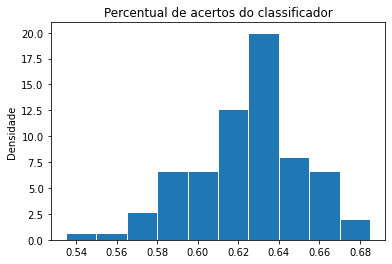

In [29]:
# Fazendo o histograma para os percentuais de acerto do classificador
plt.hist(lista_acertos, edgecolor='white', density=True)
plt.title('Percentual de acertos do classificador')
plt.ylabel('Densidade')

In [37]:
# Possíveis vantagens ou desvantagens sobre construir um classificador...
# ...considerando uma única vez a divisão da base de dados em treinamento e em teste.

print('Uma possível desvantagem, é a de o percentual de acertos do classificador ser menor do que o possível para a base de dados.', end=' ')
print(f'Por exemplo: Em uma das iterações o percentual de acerto do classificador foi de {round(min(lista_acertos), 3)} enquanto em outro foi de {round(max(lista_acertos), 3)}', end=" ")
print('assim alcançando um resultado pior do que o possível para a base de dados que se possui.')
print('Uma possível vantagem seria a maior rapidez e facilidade de construir o classificador com uma unica divisao da base de dados')

Uma possível desvantagem, é a de o percentual de acertos do classificador ser menor do que o possível para a base de dados. Por exemplo: Em uma das iterações o percentual de acerto do classificador foi de 0.535 enquanto em outro foi de 0.685 assim alcançando um resultado pior do que o possível para a base de dados que se possui.
Uma possível vantagem seria a maior rapidez e facilidade de construir o classificador com uma unica divisao da base de dados


___
## Aperfeiçoamento:

Os trabalhos vão evoluir em conceito dependendo da quantidade de itens avançados:

* Limpar: \n, :, ", ', (, ), etc SEM remover emojis
* Corrigir separação de espaços entre palavras e emojis ou entre emojis e emojis
* Propor outras limpezas e transformações que não afetem a qualidade da informação ou classificação
* Criar categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante (3 categorias: C, mais categorias conta para B)
* Explicar por que não posso usar o próprio classificador para gerar mais amostras de treinamento
* Propor diferentes cenários para Naïve Bayes fora do contexto do projeto
* Sugerir e explicar melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)


___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**